<a href="https://colab.research.google.com/github/Andip05/CL_project/blob/main/cl_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package

In [35]:
import torchvision
import numpy as np
from torch.utils.data import Subset
from random import shuffle
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Subset, TensorDataset, DataLoader

# Settings

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [37]:
args = {
    'bs': 128,
    'epochs': 8,
    'GAN_epochs': 10,
    'num_tasks': 5,
    'dataset': 'MNIST',
    'num_classes': 10,
    'in_size': 28,
    'n_channels': 1,
    'hidden_size': 64,
    'lr': 2e-4,
    'lr_cl':1e-3,
    'latent_dim':128
}

In [38]:
D_loss = list()
G_loss = list()

# Module

## Data loading and management

In [39]:
def get_dataset(dataroot, dataset):
    if dataset == 'MNIST':
        mean, std = (0.1307), (0.3081)
    elif dataset == 'CIFAR10':
        mean, std = (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)

    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=mean, std=std)])

    train_dataset = torchvision.datasets.__dict__[dataset](
        root=dataroot,
        train=True,
        download=True,
        transform=transform
    )

    val_dataset = torchvision.datasets.__dict__[dataset](
        root=dataroot,
        train=False,
        download=True,
        transform=transform
    )

    return train_dataset, val_dataset


def split_dataset(dataset, tasks_split):
    split_dataset = {}
    for e, current_classes in tasks_split.items():
        task_indices = np.isin(np.array(dataset.targets), current_classes)
        split_dataset[e] = Subset(dataset, np.where(task_indices)[0])
    return split_dataset

## Metrics & plotting

In [40]:
def dict2array(acc):
    num_tasks = len(acc)
    first_task = list(acc.keys())[0]
    sequence_length = len(acc[first_task]) if isinstance(acc[first_task], list) else num_tasks
    acc_array = np.zeros((num_tasks, sequence_length))
    for task, val in acc.items():
        acc_array[int(task), :] = val
    return acc_array


def plot_accuracy_matrix(array):
    num_tasks = array.shape[1]
    array = np.round(array, 2)
    fig, ax = plt.subplots()
    ax.imshow(array, vmin=np.min(array), vmax=np.max(array))
    for i in range(len(array)):
        for j in range(array.shape[1]):
            ax.text(j,i, array[i,j], va='center', ha='center', c='w', fontsize=15)
    ax.set_yticks(np.arange(num_tasks))
    ax.set_ylabel('Number of tasks')
    ax.set_xticks(np.arange(num_tasks))
    ax.set_xlabel('Tasks finished')
    ax.set_title(f"ACC: {np.mean(array[:, -1]):.3f} -- std {np.std(np.mean(array[:, -1])):.3f}")
    plt.show()


def plot_acc_over_time(array):
    fig, ax = plt.subplots()
    for e, acc in enumerate(array):
        ax.plot(acc, label=e)
    plt.legend()
    plt.show()


def compute_average_accuracy(array):
    num_tasks = len(array)
    avg_acc = np.sum(array[:, -1], axis=0)/num_tasks
    return avg_acc


def compute_backward_transfer(array):
    num_tasks = len(array)
    diag = np.diag(array)[:-1] # Note, we do not compute backward transfer for the last task!
    end_acc = array[:-1, -1]
    bwt = np.sum(end_acc - diag)/(num_tasks - 1)
    return bwt


def compute_forward_transfer(array, b):
    num_tasks = len(array)
    sub_diag = np.diag(array, k=-1) # Note, we do not compute forward transfer for the first task!
    fwt = np.sum(sub_diag - b[1:])/(num_tasks - 1)
    return fwt

## GAN

### Gen-Dis

In [41]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Linear(args['latent_dim'], 128),
            torch.nn.LeakyReLU(0.4),
            torch.nn.Linear(128, 256),
            torch.nn.BatchNorm1d(256, 0.8),
            torch.nn.LeakyReLU(0.4),
            torch.nn.Linear(256, 512),
            torch.nn.BatchNorm1d(512, 0.8),
            torch.nn.LeakyReLU(0.4),
            torch.nn.Linear(512, args['n_channels'] * args['in_size'] ** 2),
            torch.nn.Tanh()
        )

    def forward(self, z):
        prv = self.model(z)
        prv = prv.view(prv.size(0), args['n_channels'], args['in_size'], args['in_size'] )
        return prv

class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Linear(args['n_channels'] * args['in_size'] ** 2, 512),
            torch.nn.LeakyReLU(0.4),
            torch.nn.Linear(512, 256),
            torch.nn.LeakyReLU(0.4),
            torch.nn.Linear(256, 128),
            torch.nn.LeakyReLU(0.4),
            torch.nn.Linear(128, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, img):
        prv = img.view(img.size(0), -1)
        check = self.model(prv)
        return check

### Process

In [42]:
class GAN:
    def __init__(self, loader):
        self.loader = loader
        self.generator = Generator().to(device)
        self.discriminator = Discriminator().to(device)
        self.adversarial_loss = nn.BCELoss()
        self.opt_G = torch.optim.Adam(self.generator.parameters(), lr=args['lr'])
        self.opt_D = torch.optim.Adam(self.discriminator.parameters(), lr=args['lr'])

    def train_gan(self, loader):
        pg = sum(p.numel() for p in self.generator.parameters() if p.requires_grad)
        pd = sum(p.numel() for p in self.discriminator.parameters() if p.requires_grad)
        print("Generator params: ", pg)
        print("Disciminator params: ", pd)

        for epoch in range(args['GAN_epochs']):
            for i, (imgs, _) in enumerate(loader):
                batch_size = imgs.size(0)

                ones_true = torch.ones(batch_size, 1, requires_grad=False).to(device)
                zeros_fake = torch.zeros(batch_size, 1, requires_grad=False).to(device)

                real = imgs.to(device)

                self.opt_G.zero_grad()
                z = torch.randn(batch_size, args['latent_dim']).to(device)

                gen = self.generator(z)
                g_loss = self.adversarial_loss(self.discriminator(gen), ones_true)
                g_loss.backward()
                self.opt_G.step()

                self.opt_D.zero_grad()
                lossR = self.adversarial_loss(self.discriminator(real), ones_true)
                lossF = self.adversarial_loss(self.discriminator(gen.detach()), zeros_fake)
                d_loss = (lossR + lossF) / 2
                d_loss.backward()
                self.opt_D.step()

            D_loss.append(d_loss.item())
            G_loss.append(g_loss.item())

    def generate_samples(self, n_samples):
        self.generator.eval()
        self.discriminator.eval()

        generated_images = []
        with torch.no_grad():
            for _ in range(n_samples):
                z = torch.randn(1, 100).to(device)
                generated_image = self.generator(z).view(1, 28, 28).to(device)
                generated_images.append(generated_image)

        generated_images = torch.cat(generated_images)

        return generated_images


## MLP

In [43]:
class MLP(torch.nn.Module):
    def __init__(self, args):
        super().__init__()
        hidden_size = args['hidden_size']
        self.fc1 = torch.nn.Linear(args['in_size']**2 * args['n_channels'], hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, args['num_classes'])

    def forward(self, input):
        x = input.flatten(start_dim=1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        return x

## Class Incremental Agent

In [44]:
class Agent:
    def __init__(self, train_datasets, val_datasets):
        self.model = MLP(args).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=args['lr_cl'])
        self.criterion = torch.nn.CrossEntropyLoss()
        self.reset_acc()
        self.train_datasets = train_datasets
        self.val_datasets = val_datasets

    def reset_acc(self):
        self.acc = {key: [] for key in args['task_names']}
        self.acc_end = {key: [] for key in args['task_names']}

    def train(self):
        datasets_new = list()
        labels_new = list()
        print("Classifier params: ", sum(p.numel() for p in self.model.parameters() if p.requires_grad))

        for task, data in self.train_datasets.items():
            loader = DataLoader(data, batch_size=args['bs'], shuffle=True, drop_last=True)

            gan = GAN(loader=loader)

            gan.train_gan(loader)

            for epoch in range(args['epochs']):
                epoch_loss = 0
                total = 0
                correct = 0
                for e, (X, y) in enumerate(loader):
                    X, y = X.to(device), y.to(device)

                    if task == '0':
                        X_new, y_new = X, y
                    else:
                        old_data = torch.cat(datasets_new, dim=0).to(X.device)
                        old_labels = torch.cat(labels_new, dim=0).to(y.device)

                        X_new = torch.cat([X, old_data], dim=0).to(device)
                        y_new = torch.cat([y, old_labels], dim=0).to(device)


                    output = self.model(X_new)
                    loss = self.criterion(output, y_new)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    epoch_loss += loss.item()
                    correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y_new)
                    total += len(X_new)

                    if e % 50 == 0:
                        self.validate()

            self.validate(end_of_epoch=True)

            z = torch.randn(len(loader.dataset), args['latent_dim']).to(device)
            with torch.no_grad():
                img = gan.generator(z).detach()
                label = torch.argmax(self.model(img), dim=1)


            data = img.to(next(self.model.parameters()).device)
            labels = label.to(next(self.model.parameters()).device)

            datasets_new.append(data)
            labels_new.append(labels)


    @torch.no_grad()
    def validate(self, end_of_epoch=False):
        self.model.eval()
        for task, data in self.val_datasets.items():
            loader = torch.utils.data.DataLoader(data, batch_size=args['bs'], shuffle=True)
            correct, total = 0, 0
            for e, (X, y) in enumerate(loader):
                if torch.cuda.is_available():
                    X, y = X.cuda(), y.cuda()
                output = self.model(X)
                correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y).item()
                total += len(X)
            self.acc[task].append(correct/total)
            if end_of_epoch:
                self.acc_end[task].append(correct/total)
        self.model.train()

# Main

## Setup

In [45]:
classes = list(range(args['num_classes']))
shuffle(classes)
class_split = {str(i): classes[i*2: (i+1)*2] for i in range(args['num_tasks'])}
args['task_names'] = list(class_split.keys())

## Go

In [46]:
train, test = get_dataset(dataroot='../data/', dataset=args['dataset'])
train_tasks = split_dataset(train, class_split)
val_tasks = split_dataset(test, class_split)
agent = Agent(train_tasks, val_tasks)

In [47]:
agent.validate()
random_model_acc = [i[0] for i in agent.acc.values()]
agent.reset_acc()
agent.train()

Number of parameters classifier:  59210
Number of parameters generator:  584848
Number of parameters discriminator:  566273
Number of parameters generator:  584848
Number of parameters discriminator:  566273
Number of parameters generator:  584848
Number of parameters discriminator:  566273
Number of parameters generator:  584848
Number of parameters discriminator:  566273
Number of parameters generator:  584848
Number of parameters discriminator:  566273


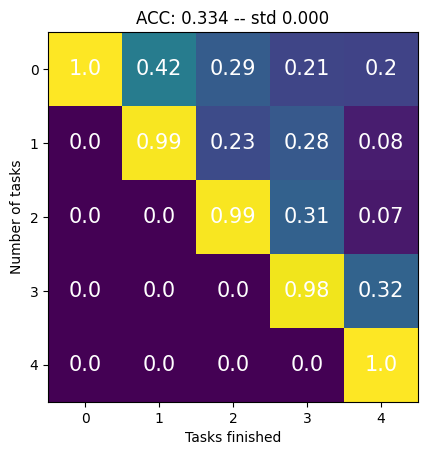

In [48]:
acc_at_end_arr = dict2array(agent.acc_end)
plot_accuracy_matrix(acc_at_end_arr)

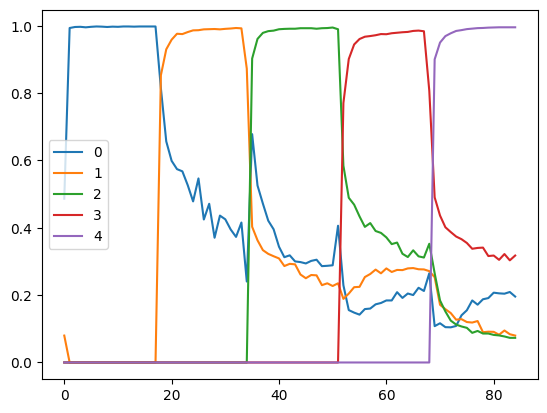

In [49]:
acc_arr = dict2array(agent.acc)
plot_acc_over_time(acc_arr)

In [50]:
print(f"The average accuracy at the end of sequence is: {compute_average_accuracy(acc_at_end_arr):.3f}")
print(f"BWT:'{compute_backward_transfer(acc_at_end_arr):.3f}'")
print(f"FWT:'{compute_forward_transfer(acc_at_end_arr, random_model_acc):.3f}'")

The average accuracy at the end of sequence is: 0.332
BWT:'-0.826'
FWT:'-0.129'
